# Lab 2: Studying anomalous rainfall

#### Learning Goals

This lab works through some "typical" climatology statistics and comparisons to observations. 

Our goals are:
1. Get you comfortable using Xarray API for computation.
2. Get you comfortable using Xarray's plotting capabilities for quickly examining high-dimensional data
3. Understand that Xarray's high-level API (e.g. groupby, resample) allow for expressive computation.

In [1]:
%config InlineBackend.figure_format = 'retina'

import arraylake as al
import xarray as xr
import numpy as np
import zarr
%xmode minimal

client = al.Client()

np.set_printoptions(threshold=10, edgeitems=2)
xr.set_options(display_expand_data=False)
# maximize I/O throughput on this machine. See `al repo tune -h` for more
zarr.config.set({"async.concurrency": 128})


Exception reporting mode: Minimal


In [2]:
client.login()

🔓 Successfully refreshed tokens!

> Token stored at /home/mambauser/.arraylake/token.json

╭──────────────────────────────────────────────── 👤 User Details ────────────────────────────────────────────────╮
│ Name: Deepak Cherian                                                                                            │
│ Email: deepak@earthmover.io                                                                                     │
│ Id: 0aa3e996-44f2-4110-970a-4264537f5f88                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🔓 Successfully logged in!

> Token stored at /home/mambauser/.arraylake/token.json

╭──────────────────────────────────────────────── 👤 User Details ────────────────────────────────────────────────╮
│ Name: Deepak Cherian                                                                                            │
│ Email: deepak@earthmover.io                                                                                     │
│ Id: 0aa3e996-44f2-4110-970a-4264537f5f88                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

We'll read the ERA5 AWS data

In [3]:
repo = client.get_repo("earthmover-public/era5-surface-aws")
session = repo.readonly_session("main")

We will do some timeseries analysis, so let's open the _temporal_ group

In [4]:
ds = xr.open_dataset(session.store, group="temporal", engine="zarr")
ds

<xarray.Dataset> Size: 40TB
Dimensions:    (time: 438312, latitude: 721, longitude: 1440)
Coordinates:
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 4MB 1975-01-01 ... 2024-12-31T23:00:00
Data variables: (12/22)
    d2         (time, latitude, longitude) float32 2TB ...
    cape       (time, latitude, longitude) float32 2TB ...
    blh        (time, latitude, longitude) float32 2TB ...
    mslp       (time, latitude, longitude) float32 2TB ...
    sd         (time, latitude, longitude) float32 2TB ...
    sst        (time, latitude, longitude) float32 2TB ...
    ...         ...
    tcc        (time, latitude, longitude) float32 2TB ...
    t2         (time, latitude, longitude) float32 2TB ...
    u10        (time, latitude, longitude) float32 2TB ...
    skt        (time, latitude, longitude) float32 2TB ...
    ssrd       (time, latitude, longitude) float32 2TB ...
    tcwv       (time, latitude, longitude) float32 2TB ...
Attributes:
    DATA_SOURCE:  ECMWF: https://cds.climate.copernicus.eu, Copernicus Climat...
    Conventions:  CF-1.6
    history:      Created by Earthmover PBC on 2025-09-06 21:03:36 by combini...

## Subset to NZ

We will subset the data.

and calculate total precipitation as recommended by https://confluence.ecmwf.int/pages/viewpage.action?pageId=111155324

In [5]:
# Define a bounding box for New Zealand
NZ_BBOX = {"longitude": slice(160, 180), "latitude": slice(-40, -50)}
subset = ds.sel(NZ_BBOX)
subset

<xarray.Dataset> Size: 128GB
Dimensions:    (time: 438312, latitude: 41, longitude: 81)
Coordinates:
  * longitude  (longitude) float64 648B 160.0 160.2 160.5 ... 179.5 179.8 180.0
  * latitude   (latitude) float64 328B -40.0 -40.25 -40.5 ... -49.5 -49.75 -50.0
  * time       (time) datetime64[ns] 4MB 1975-01-01 ... 2024-12-31T23:00:00
Data variables: (12/22)
    d2         (time, latitude, longitude) float32 6GB ...
    cape       (time, latitude, longitude) float32 6GB ...
    blh        (time, latitude, longitude) float32 6GB ...
    mslp       (time, latitude, longitude) float32 6GB ...
    sd         (time, latitude, longitude) float32 6GB ...
    sst        (time, latitude, longitude) float32 6GB ...
    ...         ...
    tcc        (time, latitude, longitude) float32 6GB ...
    t2         (time, latitude, longitude) float32 6GB ...
    u10        (time, latitude, longitude) float32 6GB ...
    skt        (time, latitude, longitude) float32 6GB ...
    ssrd       (time, latitude, longitude) float32 6GB ...
    tcwv       (time, latitude, longitude) float32 6GB ...
Attributes:
    DATA_SOURCE:  ECMWF: https://cds.climate.copernicus.eu, Copernicus Climat...
    Conventions:  CF-1.6
    history:      Created by Earthmover PBC on 2025-09-06 21:03:36 by combini...

## Quick viz

Next visualize this subset

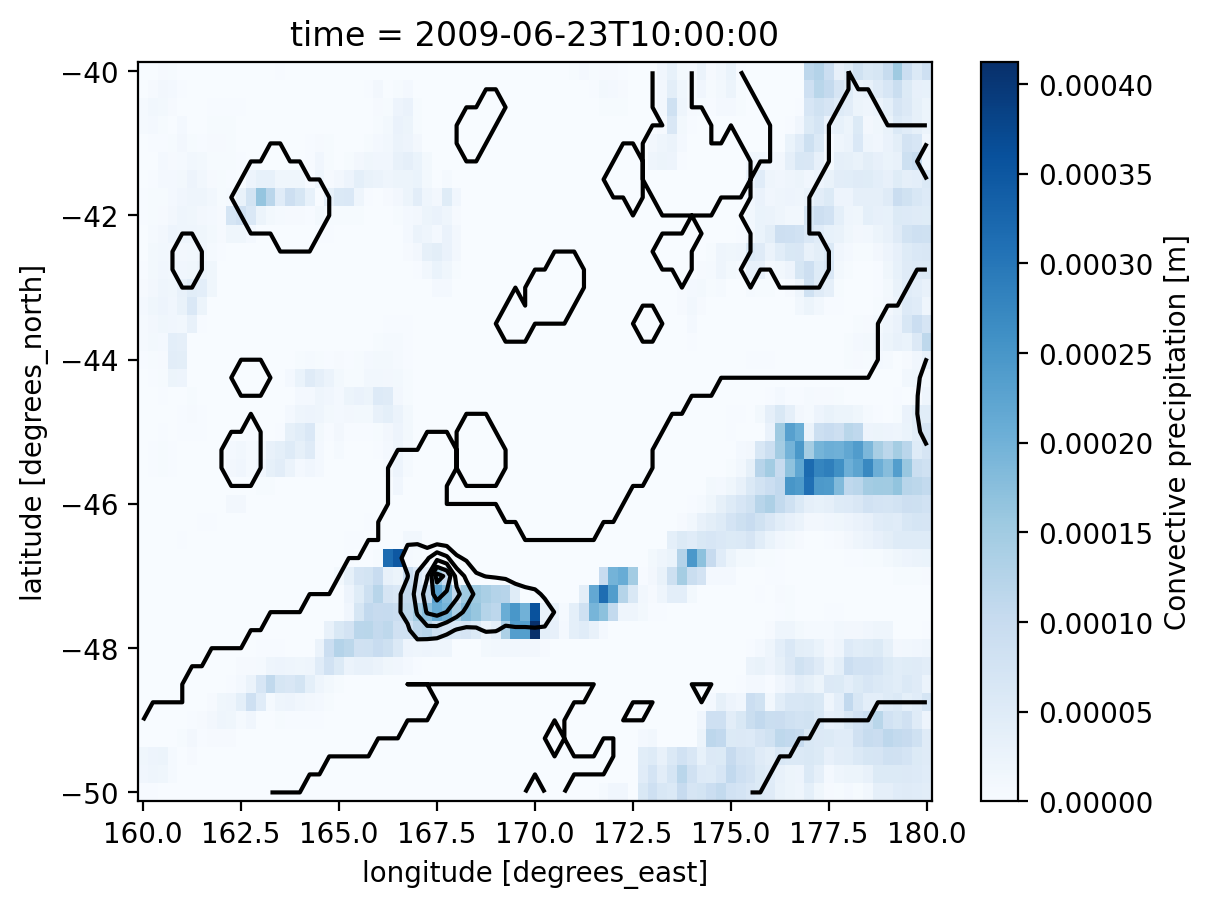

In [6]:
subset.cp.sel(time="2009-06-23 10:00").plot(cmap="Blues")
subset.lsp.sel(time="2009-06-23 10:00").plot.contour(levels=7, colors='k')

## Calculate total precip

This cell will load the total precip data in to memory, so it is fast to work with

In [7]:
%%time

total_precip = subset.cp + subset.lsp

CPU times: user 59.5 s, sys: 12.9 s, total: 1min 12s
Wall time: 17.9 s


## Let's estimate a monthly climatology

Climatology = "let's take all data for all Januaries and average them"

This is a _GroupBy_ problem.

We take the data, group by the "month" (`"time.month"`), and reduce the groups with the `mean`
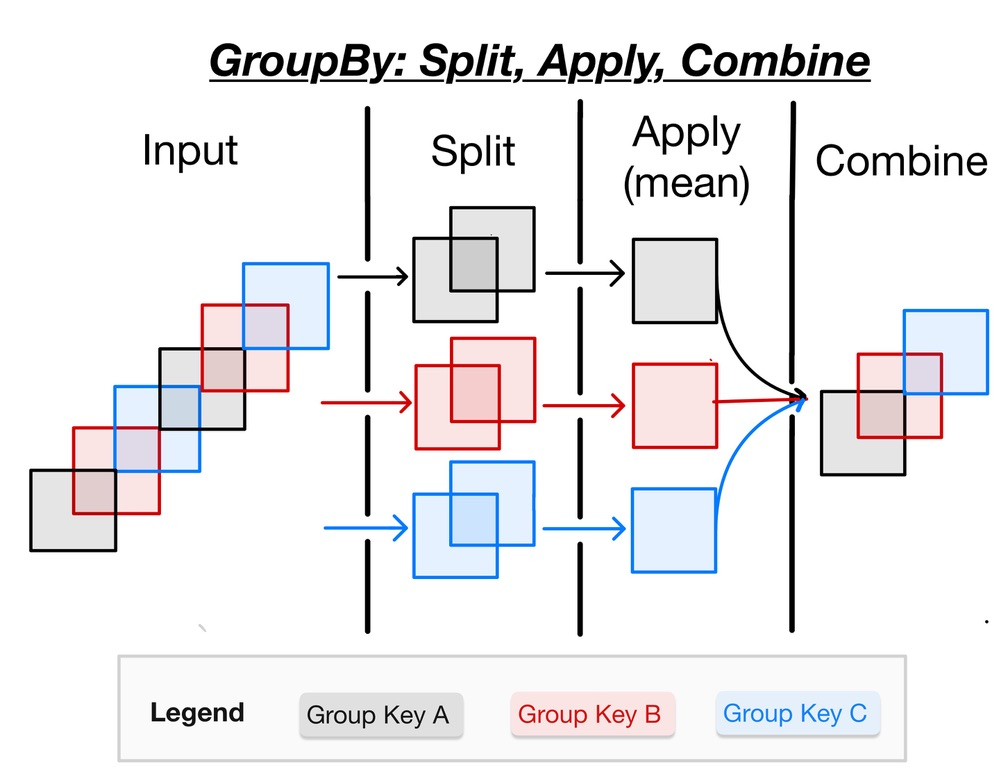

In [8]:
grouped = total_precip.groupby("time.month")
grouped

<DataArrayGroupBy, grouped over 1 grouper(s), 12 groups in total:
    'month': UniqueGrouper('month'), 12/12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12>

The GroupBy object has many methods; `mean` is one:

In [9]:
clim = grouped.mean()
clim

<xarray.DataArray (month: 12, latitude: 41, longitude: 81)> Size: 159kB
0.0001236 0.0001201 0.0001162 0.0001135 ... 8.698e-05 8.757e-05 8.827e-05
Coordinates:
  * longitude  (longitude) float64 648B 160.0 160.2 160.5 ... 179.5 179.8 180.0
  * latitude   (latitude) float64 328B -40.0 -40.25 -40.5 ... -49.5 -49.75 -50.0
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

Let's look at some maps

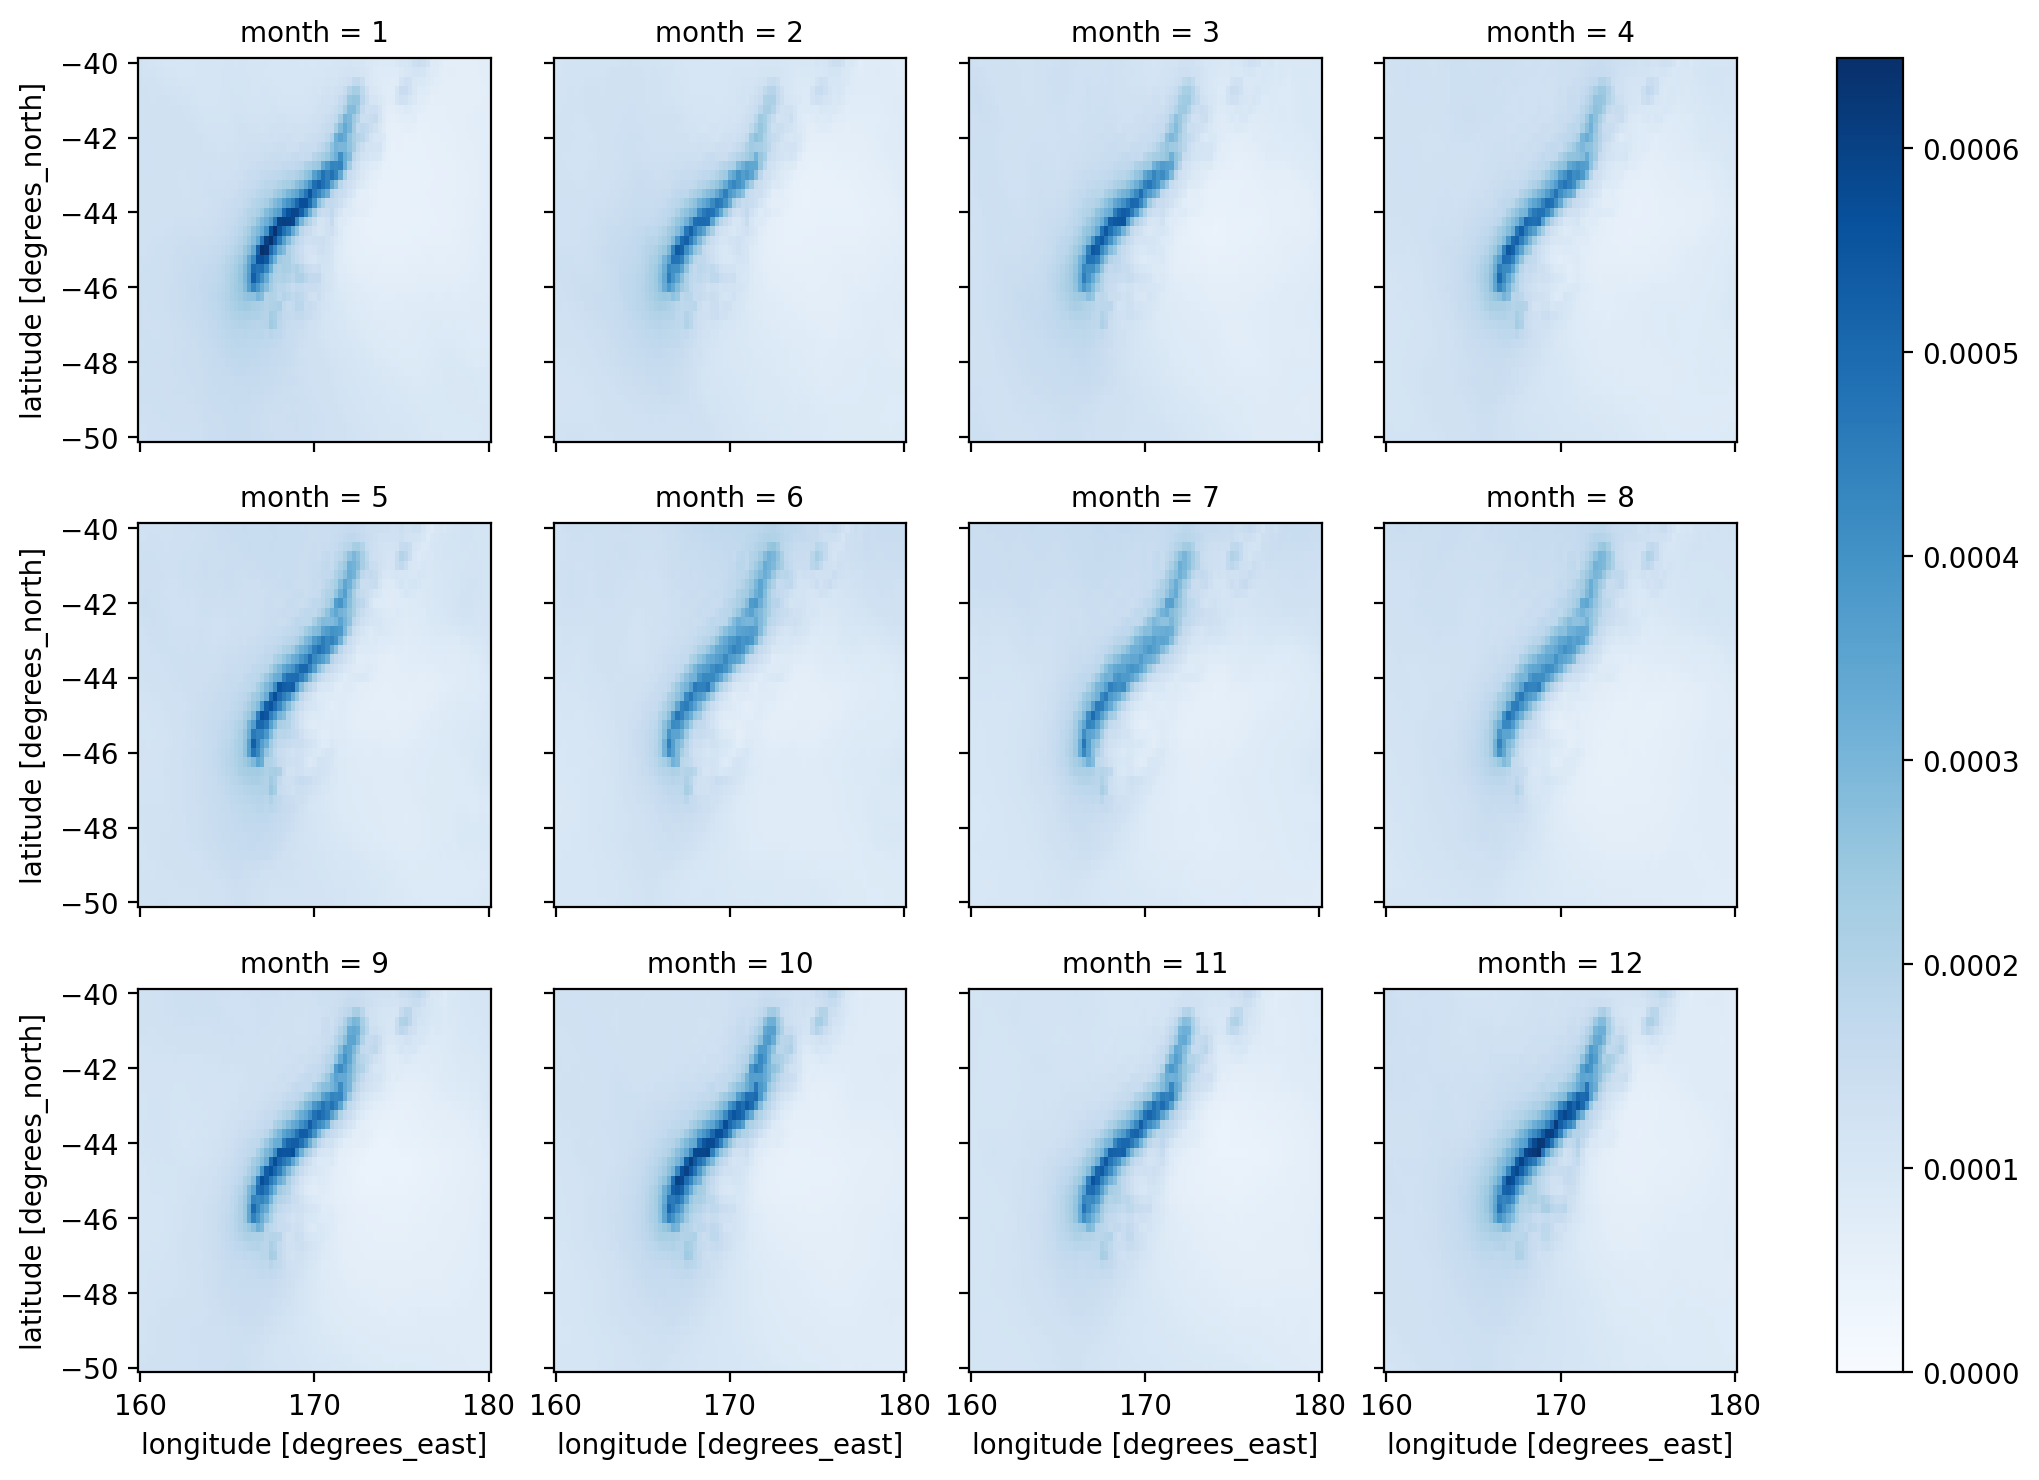

In [10]:
clim.plot(col="month", col_wrap=4, cmap="Blues", vmin=0, size=2.5)

### Exercise 1 : plot the monthly mean precip at Wellington

Location: 41°18′S 174°47′E

<details>

    ```python
    wellington = {"latitude": -41 + 18 / 60, "longitude": 174 + 47 / 60}
    # apparently snow is "exceptionally rare"
    clim.total_precip.sel(wellington, method="nearest").plot()
    ```
</details>

### Exercise 2: Repeat the above for Mt. Hutt 

Latitude: -43.471667°, Longitude: 171.526444°

<details>
    
    ```python
    hutt = {"latitude": -43.471667, "longitude": 171.526444}
    subset.total_precip.sel(hutt, method="nearest").plot()
    ```
    
</details>

## Estimate anomalies relative to monthly mean

Xarray has fancy syntax for computing group anomalies : subtract the mean field from the GroupBy object

In [11]:
anom = total_precip.groupby("time.month") -  clim
anom

<xarray.DataArray (time: 438312, latitude: 41, longitude: 81)> Size: 6GB
nan nan nan nan nan ... -8.394e-05 -8.346e-05 -8.412e-05 -8.471e-05 -8.541e-05
Coordinates:
  * longitude  (longitude) float64 648B 160.0 160.2 160.5 ... 179.5 179.8 180.0
  * latitude   (latitude) float64 328B -40.0 -40.25 -40.5 ... -49.5 -49.75 -50.0
  * time       (time) datetime64[ns] 4MB 1975-01-01 ... 2024-12-31T23:00:00
    month      (time) int64 4MB 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12


Let's plot the anomalies for Mt. Hutt

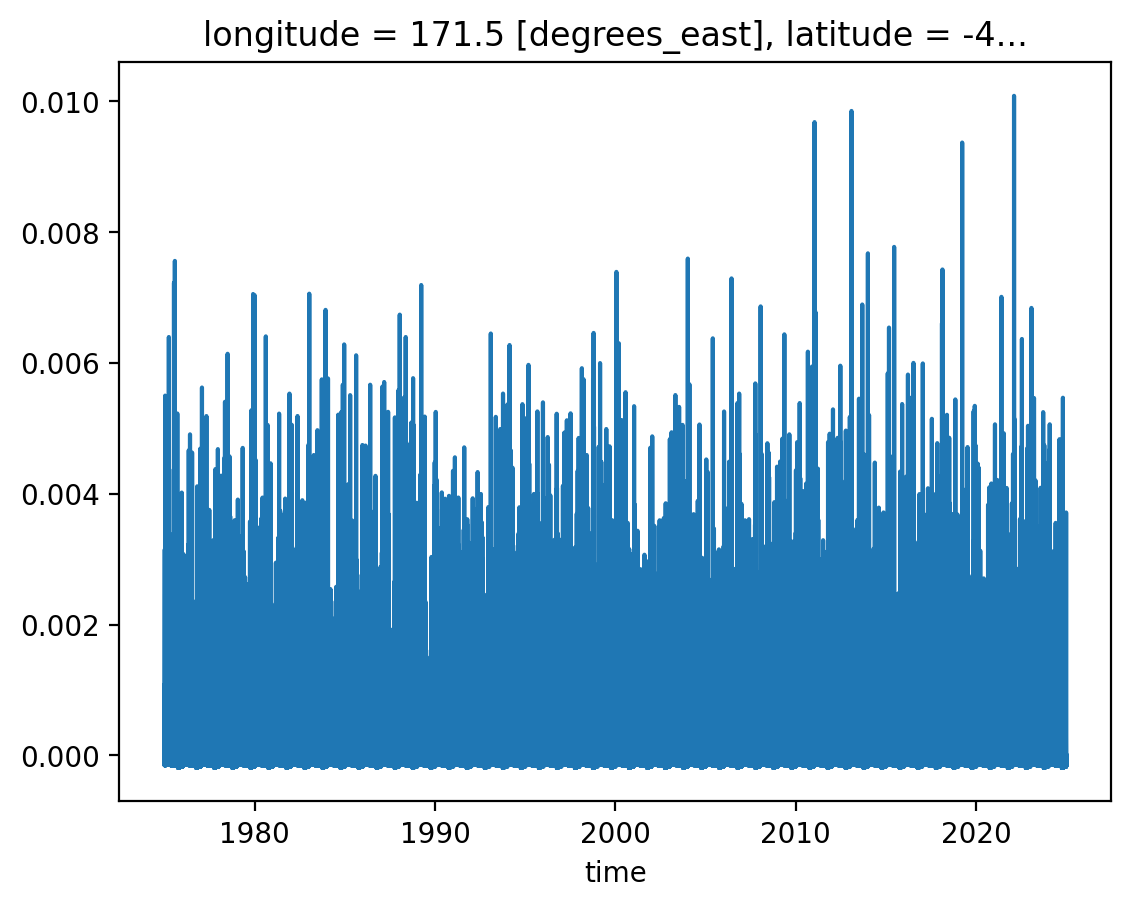

In [12]:
hutt = {"latitude": -43.471667, "longitude": 171.526444}
anom.sel(hutt, method="nearest").plot()

### Resampling to a different frequency

It's useful to smooth that. Let's resample to a monthly frequency. 
1. We use the pandas frequency string "MS" -- "monthly frequency at month-start".
2. We will accumulate the precip using `sum` to get a "surplus" or "deficit" 

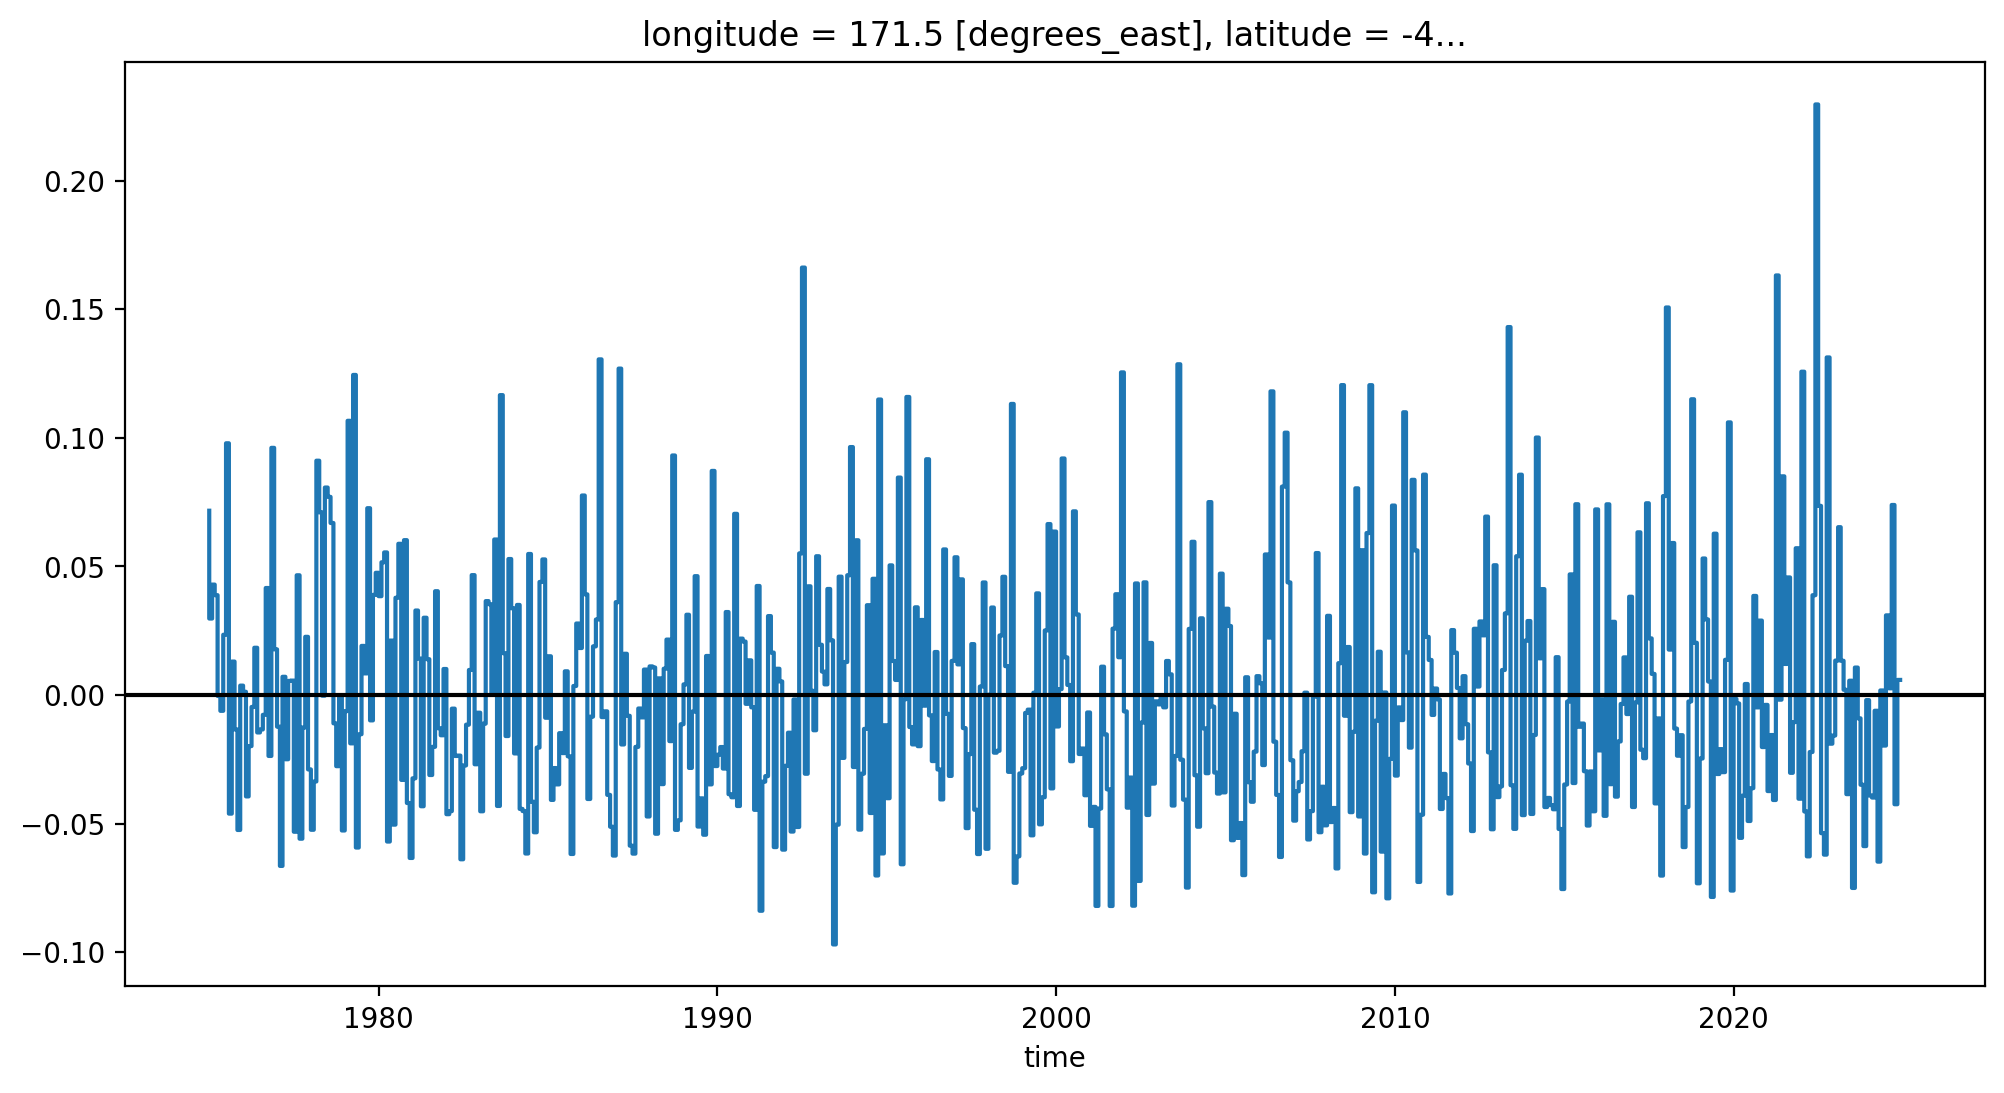

In [13]:
import matplotlib.pyplot as plt

anom.sel(hutt, method="nearest").resample(time="MS").sum().plot.step(size=6, aspect=2)
plt.axhline(0, color='k')

## Exercise: Compare the ERA5 total precip to precip from the Met Station data

1. Use the data at https://app.earthmover.io/earthsciencesnz/met-stations/
2. Pick your favorite location.
3. Plot time series of the monthly surplus/deficit at that location from both ERA5 and the weather station data.

In [14]:
repo2 = client.get_repo("earthsciencesnz/met-stations")
obs = xr.open_dataset(
    repo2.readonly_session("main").store, group="monthly", engine="zarr", decode_timedelta=False
)
obs

<xarray.Dataset> Size: 2MB
Dimensions:       (time: 600, station: 53)
Coordinates:
    longitude     (station) float64 424B ...
  * station       (station) <U5 1kB '91490' '93004' '93012' ... '93997' 'NZNS0'
    elevation     (station) float64 424B ...
    station_name  (station) <U40 8kB ...
    latitude      (station) float64 424B ...
  * time          (time) datetime64[ns] 5kB 1975-01-01 1975-02-01 ... 2024-12-01
Data variables:
    tavg          (time, station) float64 254kB ...
    tmin          (time, station) float64 254kB ...
    pres          (time, station) float64 254kB ...
    tmax          (time, station) float64 254kB ...
    prcp          (time, station) float64 254kB ...
    tsun          (time, station) float64 254kB ...
    wspd          (time, station) float64 254kB ...
Attributes:
    title:                New Zealand Monthly Meteorological Data
    source:               Meteostat
    time_coverage_start:  1975-01-01T00:00:00
    time_coverage_end:    2024-12-31T00:00:00
    geospatial_bounds:    New Zealand
    created:              2025-09-08T17:24:51.959808
    number_of_stations:   53
    temporal_resolution:  monthly

#### Construct monthly accumulated precip

In [15]:
accum = total_precip.resample(time="MS").sum()
accum

<xarray.DataArray (time: 600, latitude: 41, longitude: 81)> Size: 8MB
0.1171 0.1013 0.09078 0.09563 0.1014 ... 0.04945 0.0499 0.04984 0.05049 0.04997
Coordinates:
  * longitude  (longitude) float64 648B 160.0 160.2 160.5 ... 179.5 179.8 180.0
  * latitude   (latitude) float64 328B -40.0 -40.25 -40.5 ... -49.5 -49.75 -50.0
  * time       (time) datetime64[ns] 5kB 1975-01-01 1975-02-01 ... 2024-12-01

#### Interpolate to station locations

In [16]:
atobs = accum.interp(latitude=obs.latitude, longitude=obs.longitude)
atobs

<xarray.DataArray (time: 600, station: 53)> Size: 254kB
nan nan nan nan nan nan nan nan nan ... nan nan nan nan nan nan nan 0.07784
Coordinates:
  * time          (time) datetime64[ns] 5kB 1975-01-01 1975-02-01 ... 2024-12-01
    latitude      (station) float64 424B 1.983 -34.43 -35.1 ... -29.25 -41.3
    longitude     (station) float64 424B -157.5 172.7 173.3 ... -177.9 173.2
  * station       (station) <U5 1kB '91490' '93004' '93012' ... '93997' 'NZNS0'
    elevation     (station) float64 424B 3.0 191.0 54.0 82.0 ... 38.0 38.0 5.0
    station_name  (station) <U40 8kB 'Christmas / Cassidy' ... 'Nelson / Monaco'

#### Subsample to stations with precip data

In [17]:
counts = atobs.count("time")
cleaned = atobs.sel(station=counts > 0)
cleaned

<xarray.DataArray (time: 600, station: 28)> Size: 134kB
0.07512 0.08279 0.08592 0.08592 0.06451 ... 0.1518 0.114 0.1164 0.1767 0.07784
Coordinates:
  * time          (time) datetime64[ns] 5kB 1975-01-01 1975-02-01 ... 2024-12-01
    latitude      (station) float64 224B -40.2 -40.32 -40.9 ... -47.27 -41.3
    longitude     (station) float64 224B 175.4 175.6 175.0 ... 170.2 167.4 173.2
  * station       (station) <U5 560B '93401' '93404' '93417' ... '93909' 'NZNS0'
    elevation     (station) float64 224B 50.0 45.0 7.0 7.0 ... 1.0 1.0 101.0 5.0
    station_name  (station) <U40 4kB 'Ohakea' ... 'Nelson / Monaco'

#### Align to a common grid

In [20]:
cleaned_obs, cleaned_model = xr.align(obs.prcp, atobs.sel(station=counts>0), join="inner")

#### Calculate correlation coefficient

In [31]:
corr = xr.corr(cleaned_obs, cleaned_model, dim="time")
corr = corr.to_dataset(name="corr")
corr

<xarray.Dataset> Size: 6kB
Dimensions:       (station: 28)
Coordinates:
  * station       (station) <U5 560B '93401' '93404' '93417' ... '93909' 'NZNS0'
    longitude     (station) float64 224B 175.4 175.6 175.0 ... 170.2 167.4 173.2
    elevation     (station) float64 224B 50.0 45.0 7.0 7.0 ... 1.0 1.0 101.0 5.0
    station_name  (station) <U40 4kB 'Ohakea' ... 'Nelson / Monaco'
    latitude      (station) float64 224B -40.2 -40.32 -40.9 ... -47.27 -41.3
Data variables:
    corr          (station) float64 224B 0.9535 0.8859 0.8488 ... 0.9424 0.953
    counts        (station) int64 224B 43 43 233 209 43 211 ... 328 0 43 43 43

#### Viz results

Grab DEM data for context

In [40]:
repo3 = client.get_repo("earthsciencesnz/copernicus_dem")
dem = xr.open_dataset(
    repo3.readonly_session("main").store, group="90m_new_zealand_complete", engine="zarr"
).coarsen(latitude=50, longitude=50).mean()

/opt/coiled/env/lib/python3.12/site-packages/xarray/plot/dataarray_plot.py:2012: UserWarning: The following kwargs were not used by contour: 'lw'
  primitive = ax.contour(x, y, z, **kwargs)


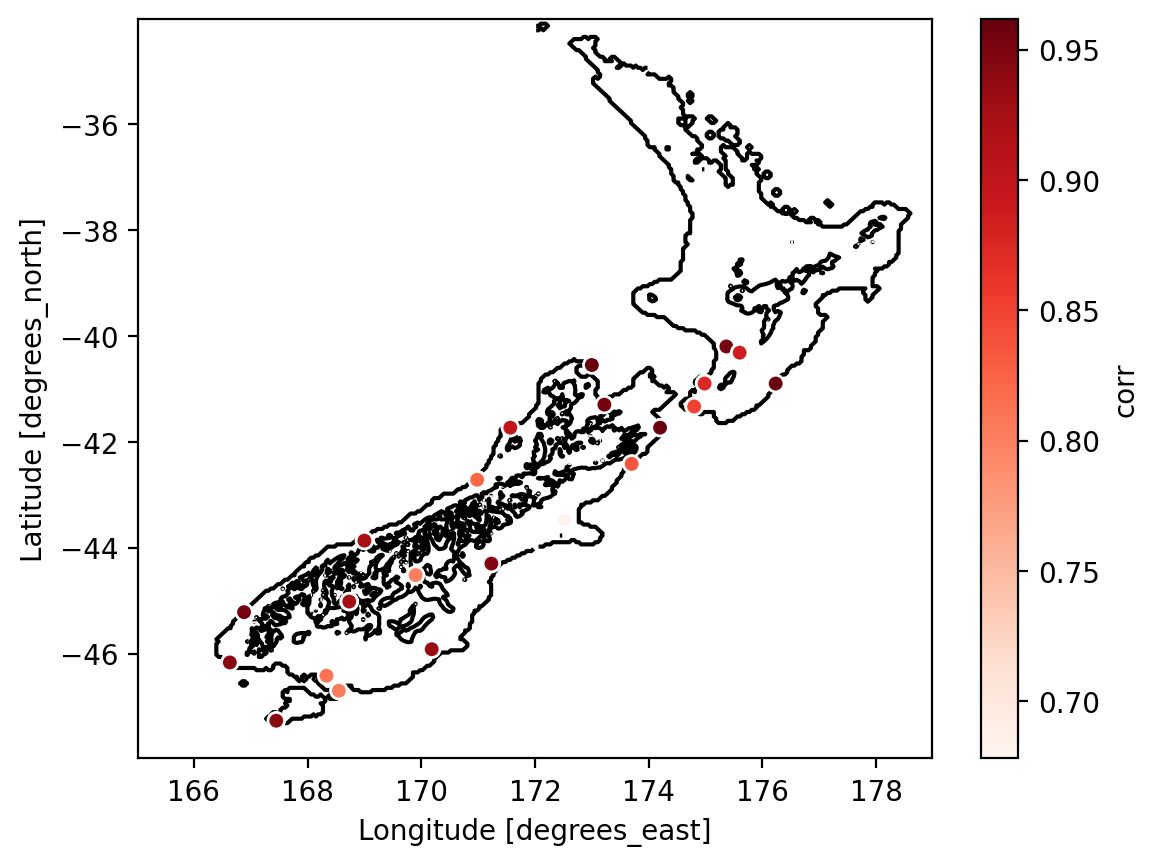

In [41]:
corr.plot.scatter(
    x="longitude", y="latitude", hue="corr", cmap="Reds"
)
dem.elevation.plot.contour(levels=8, colors='k', lw=0.15, zorder=-1)

We need some more context. Let's add number of observations to the viz.

In [38]:
corr["counts"] = cleaned_obs.count("time")

/opt/coiled/env/lib/python3.12/site-packages/xarray/plot/dataarray_plot.py:2012: UserWarning: The following kwargs were not used by contour: 'lw'
  primitive = ax.contour(x, y, z, **kwargs)


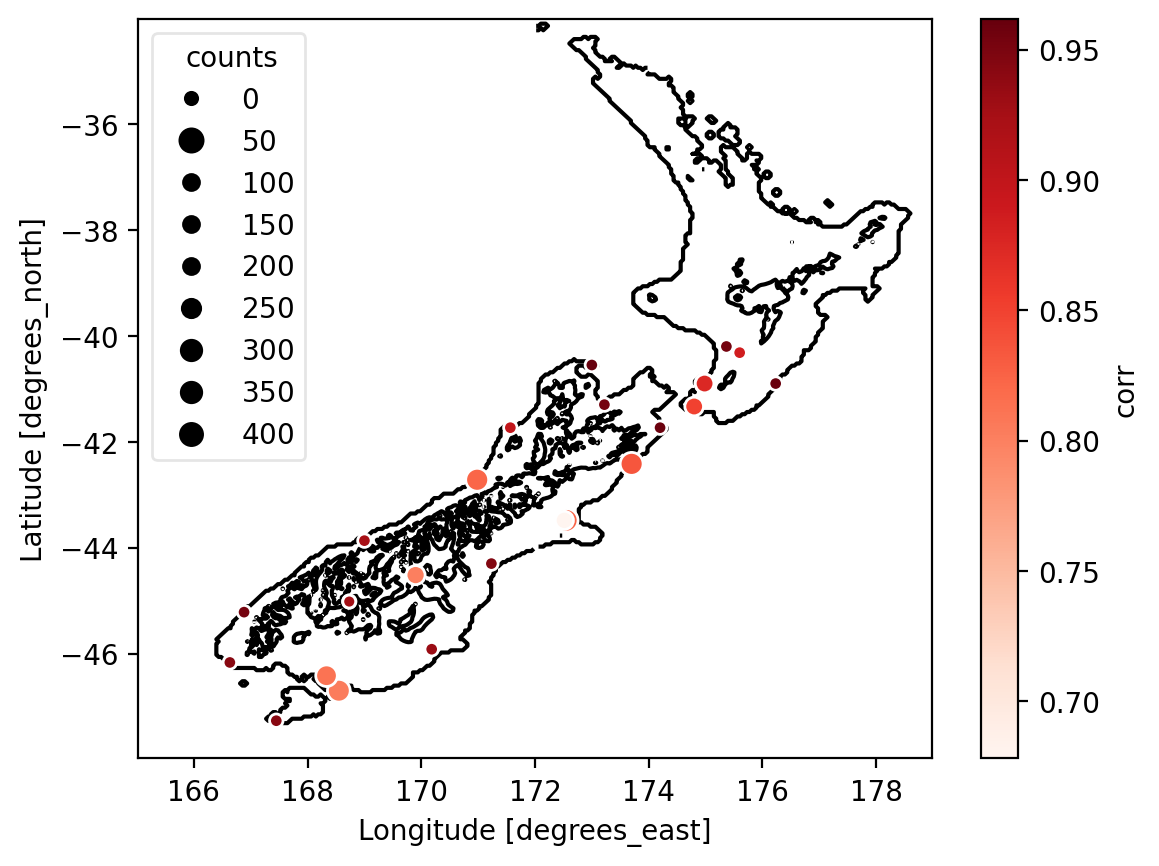

In [39]:
corr.plot.scatter(
    x="longitude", y="latitude", hue="corr", cmap="Reds", markersize="counts"
)
dem.elevation.plot.contour(levels=8, colors='k', lw=0.15, zorder=-1)

Notice that many of the high correlation locations have few observations. We probably want to filter those out.

(also the legend is clearly wrong)

In [51]:
corr = corr.where(corr.counts>  60, drop=True)

/opt/coiled/env/lib/python3.12/site-packages/xarray/plot/dataarray_plot.py:2012: UserWarning: The following kwargs were not used by contour: 'lw'
  primitive = ax.contour(x, y, z, **kwargs)


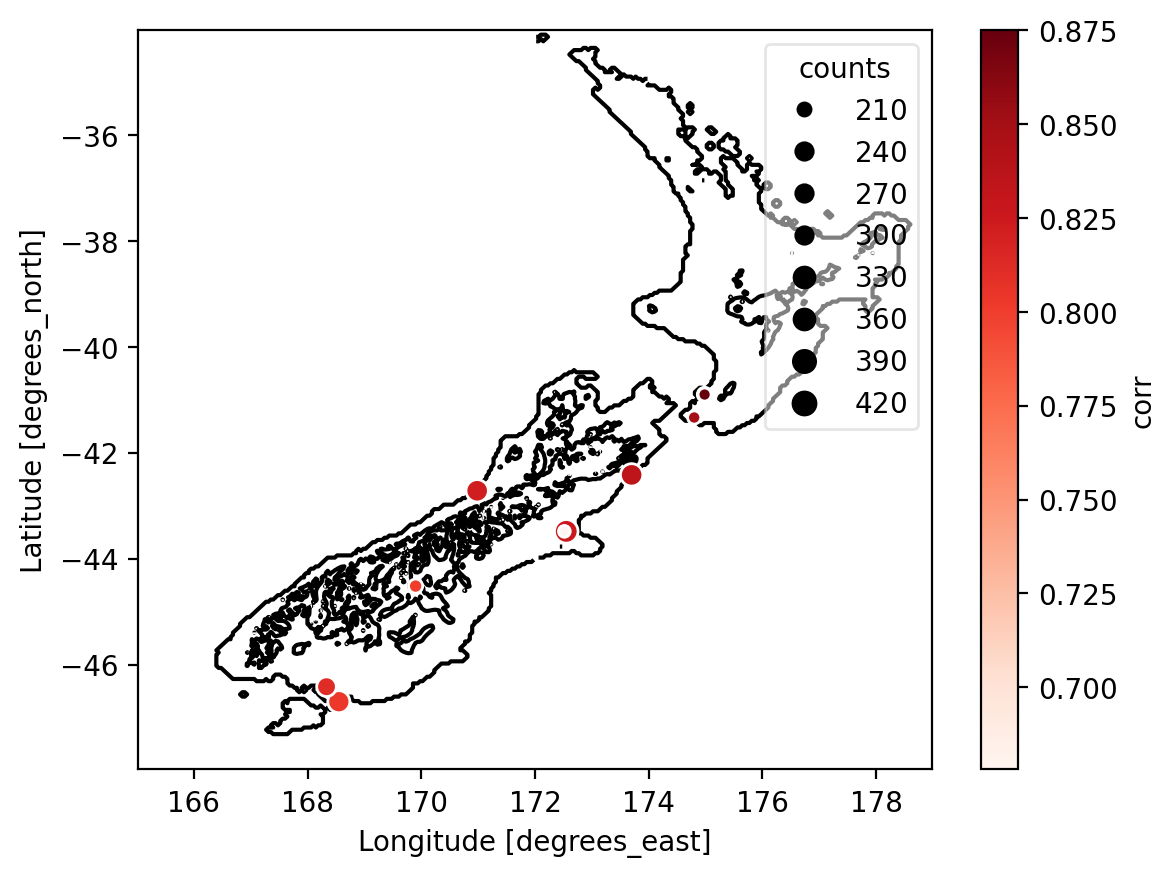

In [52]:
corr.plot.scatter(
    x="longitude", y="latitude", hue="corr", cmap="Reds", markersize="counts"
)
dem.elevation.plot.contour(levels=8, colors='k', lw=0.15, zorder=-1)